# Quick Start

This is a quick start reference for an overview of what the code can do. For more details, please visit the other parts of the documentation.

In [1]:
# preamble
from __future__ import annotations

import matplotlib.pyplot as plt
import numpy as np
import pyccl as ccl
from init_halo_model import (  # halo model
    a_arr,
    bM,
    cM_relation,
    cosmo,
    hmc,
    hmd,
    k_arr,
    r_arr,
)

import glasz

# Initialize the halo model

# CMASS PARAMETERS
z_lens = 0.55  # Mean z for CMASS
a_sf = 1 / (1 + z_lens)

# constituent fractions
fb = cosmo["Omega_b"] / cosmo["Omega_m"]  # Baryon fraction
fc = cosmo["Omega_c"] / cosmo["Omega_m"]  # CDM fraction

# define 2-halo term
xi_mm_2h = glasz.profiles.calc_xi_mm_2h(
    cosmo, hmd, cM_relation, hmc, k_arr, a_arr, r_arr, a_sf
)

### Profiles

In [3]:
# Halo Mass
M_halo = 3e13

# 2-halo Amplitude
A_2h = 0.7

# GNFW Parameters
alpha = 1.0
beta = 3.0
gamma = 0.2
x_c = 0.5

Rb = 10 * (hmd.get_radius(cosmo, M_halo, a_sf) / a_sf)

# COMPUTE GNFW AMPLITUDE
prof_nfw = ccl.halos.HaloProfileNFW(
    mass_def=hmd, concentration=cM_relation, truncated=False, fourier_analytic=True
)

prof_baryons = glasz.profiles.HaloProfileGNFW(
    hmd,
    rho0=1.0,
    alpha=alpha,
    beta=beta,
    gamma=gamma,
    x_c=x_c,
)

prof_baryons.normalize(cosmo, Rb, M_halo, a_sf, prof_nfw)


# COMPUTE 3D DENSITY PROFILES
def rho_2h(r):
    return (
        xi_mm_2h(r)
        * bM(cosmo, M_halo, a_sf)
        * ccl.rho_x(cosmo, a_sf, "matter", is_comoving=True)
        * A_2h
    )


prof_baryons.rho_2h = rho_2h  # add 2-halo term to baryon profile

prof_matter = glasz.profiles.MatterProfile(
    mass_def=hmd, concentration=cM_relation, rho_2h=rho_2h
)

### Galaxy-Galaxy Lensing (GGL)

In [4]:
R = np.geomspace(
    1e-2, 6e1, 100
)  # Mpc/h comoving units (like observations of Amon & Robertson et al. 2022)

# COMPUTE ΔΣ PROFILE
ds_b = (
    fb
    * glasz.GGL.calc_ds(
        cosmo,
        R / cosmo["h"],  # convert from Mpc/h to Mpc
        M_halo,
        a_sf,
        prof_baryons,
    )
    / cosmo["h"]
)  # convert from Msun/pc^2 to h Msun/pc^2


ds_dm = (
    fc
    * glasz.GGL.calc_ds(
        cosmo,
        R / cosmo["h"],  # convert from Mpc/h to Mpc
        M_halo,
        a_sf,
        prof_matter,
    )
    / cosmo["h"]
)  # convert from Msun/pc^2 to h Msun/pc^2

ds = ds_b + ds_dm

### kinetic Sunyaev-Zeldovich (kSZ) Effect

In [19]:
# COMPUTE kSZ PROFILE
theta = np.geomspace(0.5, 6.5, 20)


def rho_gas_3D(r):
    """
    We need to be careful about comoving units here. The kSZ code assumes
    that the density profile is in physical units. The array which it will
    be feeding into this function is in physical units r = aχ. The CCL
    profile assumes comoving units so we need to convert the input to
    comoving units before passing it to the profile. Then we need to convert
    the density profile back into physical units before returning it by
    dividing by the scale factor a^3.
    """
    return (fb * prof_baryons.real(cosmo, r / a_sf, M_halo, a_sf)) / a_sf**3


T_kSZ_150 = glasz.kSZ.create_T_kSZ_profile(theta, z_lens, rho_gas_3D, "f150", cosmo)

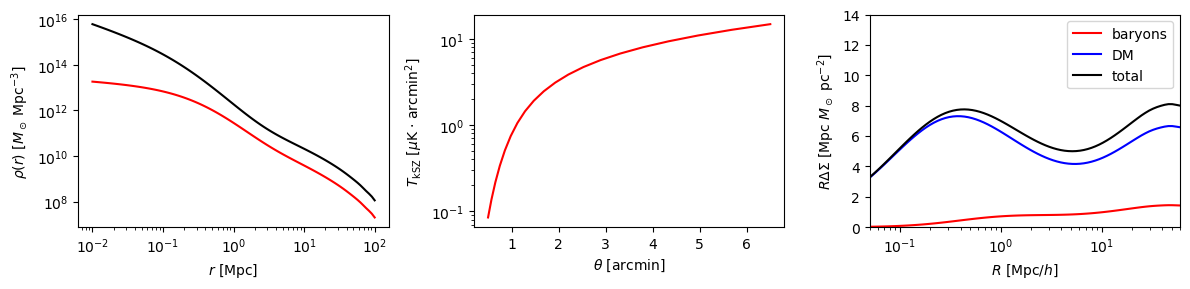

In [24]:
f, ax = plt.subplots(1, 3, figsize=(12, 3))

ax[0].loglog(r_arr, prof_baryons.real(cosmo, r_arr, M_halo, a_sf) * fb, color="red")
ax[0].loglog(r_arr, prof_matter.real(cosmo, r_arr, M_halo, a_sf), color="black")
ax[0].set_xlabel("$r$ [Mpc]")
ax[0].set_ylabel(r"$\rho(r)$ [$M_\odot$ Mpc$^{-3}$]")

ax[1].semilogy(theta, T_kSZ_150 * glasz.constants.sr2sqarcmin, color="red")
ax[1].set_xlabel(r"$\theta$ [arcmin]")
ax[1].set_ylabel(r"$T_{\rm kSZ}$ [$\mu$K $\cdot$ arcmin$^2$]")

ax[2].semilogx(R, R * ds_b, label="baryons", color="red")
ax[2].semilogx(R, R * ds_dm, label="DM", color="blue")
ax[2].semilogx(R, R * ds, label="total", color="black")
ax[2].set_xlabel(r"$R$ [Mpc/$h$]")
ax[2].set_ylabel(r"$R \Delta\Sigma$ [Mpc $M_\odot$ pc$^{-2}$]")
ax[2].legend()
ax[2].set_ylim(0, 14)
ax[2].set_xlim(0.05, 60)
plt.tight_layout()